In [ ]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance
import os
import shap

# Recreate Neural Network and import functions

In [2]:
class RatingsNet(nn.Module):
    def __init__(self, input_shape: int):
        super().__init__()
        self.hidden1 = nn.Linear(input_shape, 256)
        self.hidden2 = nn.Linear(256, 512)
        self.hidden3 = nn.Linear(512, 256)
        self.hidden4 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 6)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.08, inplace=False)

    def forward(self, x):
        x = self.tanh(self.hidden1(x))
        x = self.dropout(x)
        x = self.tanh(self.hidden2(x))
        x = self.dropout(x)
        x = self.tanh(self.hidden3(x))
        x = self.dropout(x)
        x = self.tanh(self.hidden4(x))
        x = self.dropout(x)
        x = self.softmax(self.output(x))
        return x

In [4]:
def import_data():
    df = pd.read_csv(os.path.join('input', 'corporateCreditRatingWithFinancialRatios.csv'))
    df['index']=df.index
    # df = df.loc[df['Rating Agency'] == "Standard & Poor's Ratings Services"]

    rating_mapping = {
        'AAA': 'Sehr Hohe Bonität', 'AA+': 'Sehr Hohe Bonität', 'AA': 'Sehr Hohe Bonität', 'AA-': 'Sehr Hohe Bonität', 
        'A+': 'Gute Bonität', 'A': 'Gute Bonität', 'A-': 'Gute Bonität', 
        'BBB+': 'Befriedigende Bonität', 'BBB': 'Befriedigende Bonität', 'BBB-': 'Befriedigende Bonität', 
        'BB+': 'Angespannte Bonität', 'BB': 'Angespannte Bonität', 'BB-': 'Angespannte Bonität',
        'B+': 'Mangelhafte Bonität', 'B': 'Mangelhafte Bonität', 'B-': 'Mangelhafte Bonität',
        'CCC+': 'Ungenügende Bonität', 'CCC': 'Ungenügende Bonität', 'CCC-': 'Ungenügende Bonität', 
        'CC': 'Ungenügende Bonität', 'C': 'Ungenügende Bonität', 
        'D': 'Insolvent'
    }
    # Apply the mapping to the 'Rating' column
    df['Rating Category'] = df['Rating'].map(rating_mapping)
    df = df[df['Rating Category'].notna()]
    df = df.loc[df['Rating Category']!="Insolvent"]

    # Encode classes as integers
    encoder = LabelEncoder()
    df['Sector'] = encoder.fit_transform(df.Sector.values)

    df['Rating Category Encoded'] = df['Rating Category'].apply(lambda x: ['Sehr Hohe Bonität', 'Gute Bonität', 
                                                                        'Befriedigende Bonität', 'Angespannte Bonität', 
                                                                        'Mangelhafte Bonität', 'Ungenügende Bonität'].index(x))
    
    return df


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
assert(torch.cuda.get_device_name(0) == 'NVIDIA GeForce RTX 3070 Ti Laptop GPU')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Model will run on {device}.")

torch.manual_seed(42)

cols_to_keep = ['Current Ratio',
'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
'EBIT Margin', 'Asset Turnover',
'ROE - Return On Equity', 'Return On Tangible Equity',
'Operating Cash Flow Per Share', 'Free Cash Flow Per Share', 'Sector']

df = import_data()


X = df[cols_to_keep]
y = df.loc[:, df.columns == 'Rating Category Encoded'].to_numpy()

onehot = OneHotEncoder(sparse_output=False).fit(y)
y = onehot.transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

Model will run on cpu.


In [6]:
model = RatingsNet()

model.load_state_dict(torch.load(os.path.join('torch_weights', 'best_weights.pt')))

<All keys matched successfully>

In [26]:
X_train.shape

torch.Size([6161, 11])

# Calculate SHAP values (will partially use GPU for tensor operations)

C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 1638/1638 [11:21<00:00,  2.40it/s]


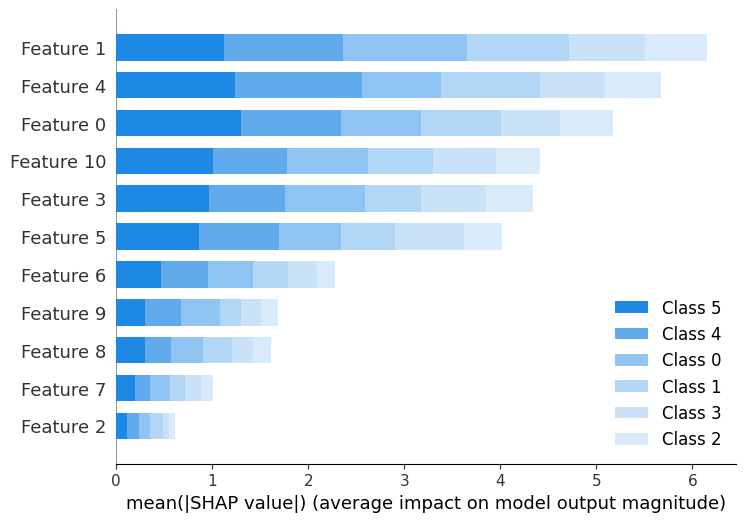

In [7]:

torch.set_num_threads(6)

# use kmeans to summarize the dataset

kmeans_background = shap.kmeans(X_train.detach().cpu().numpy(), 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def f(X):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy()

explainer = shap.KernelExplainer(f, kmeans_background)
shap_values = explainer.shap_values(X_test.detach().cpu().numpy())
shap.summary_plot(shap_values, X_test.detach().cpu().numpy())

## Create in-depth class analysis with beeswarm plots

C:\Users\leand\AppData\Local\Temp\ipykernel_11744\2751201916.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap(Color01,128)
C:\Users\leand\AppData\Local\Temp\ipykernel_11744\2751201916.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap(Color04,128)
C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\shap\plots\summary.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,


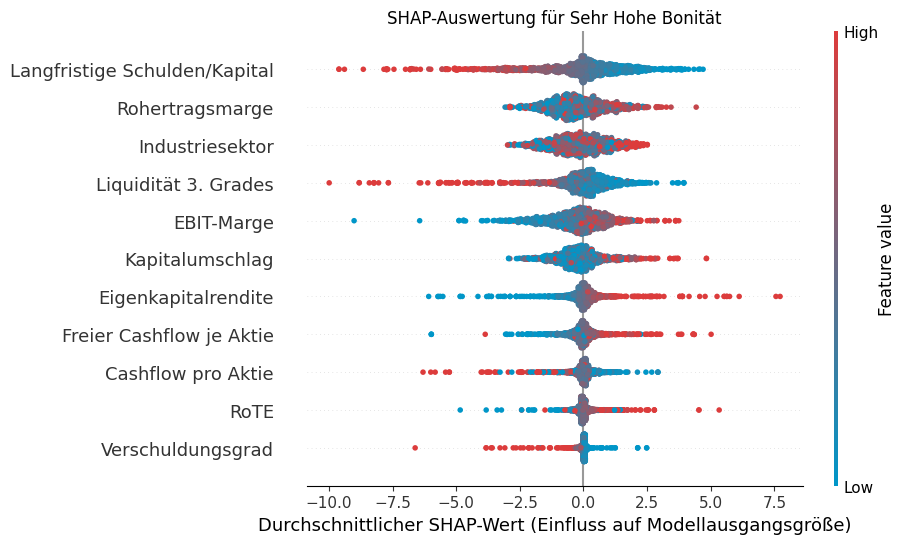

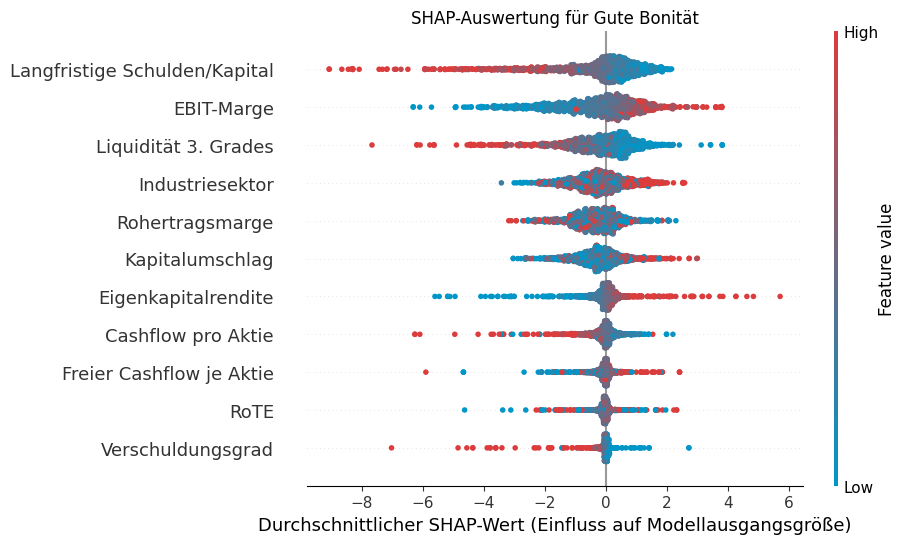

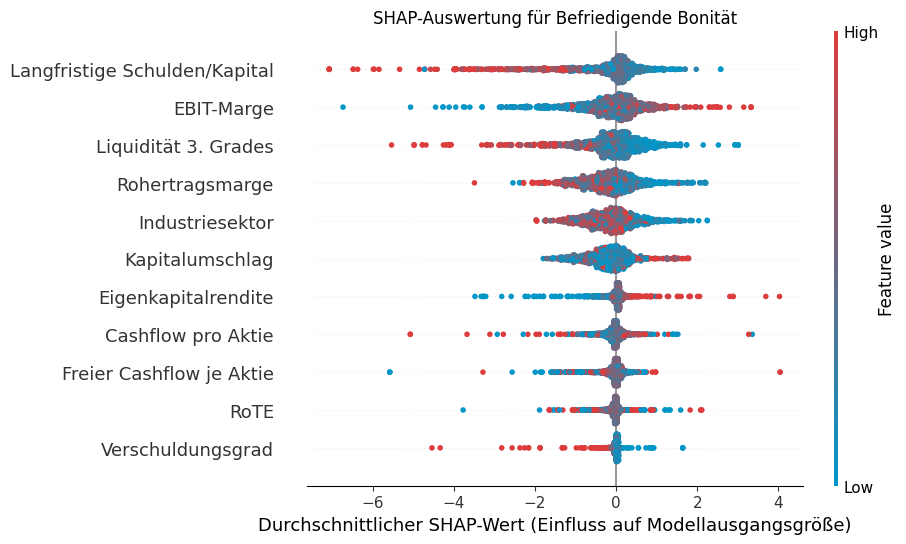

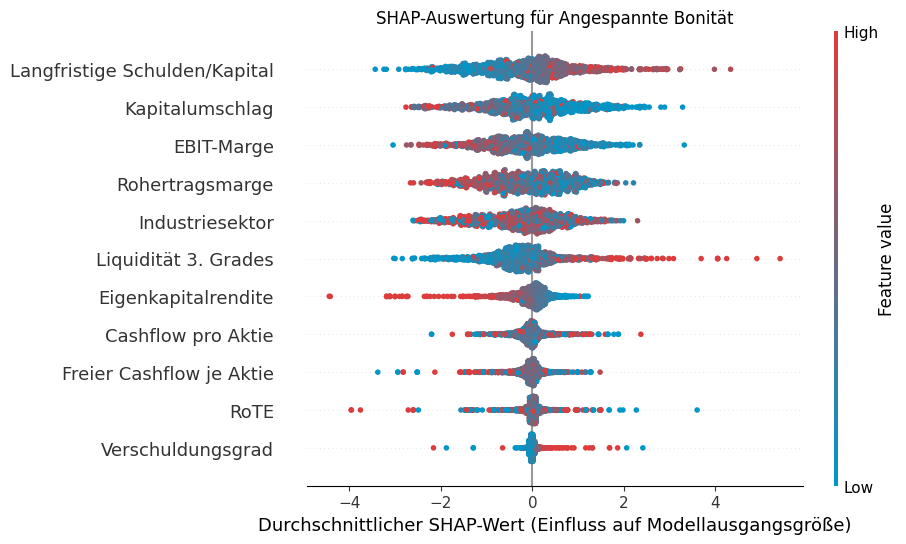

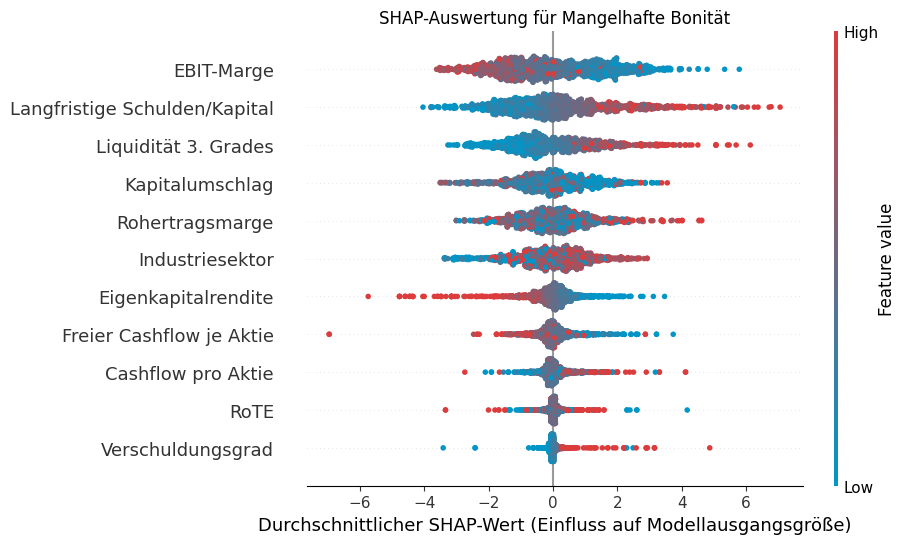

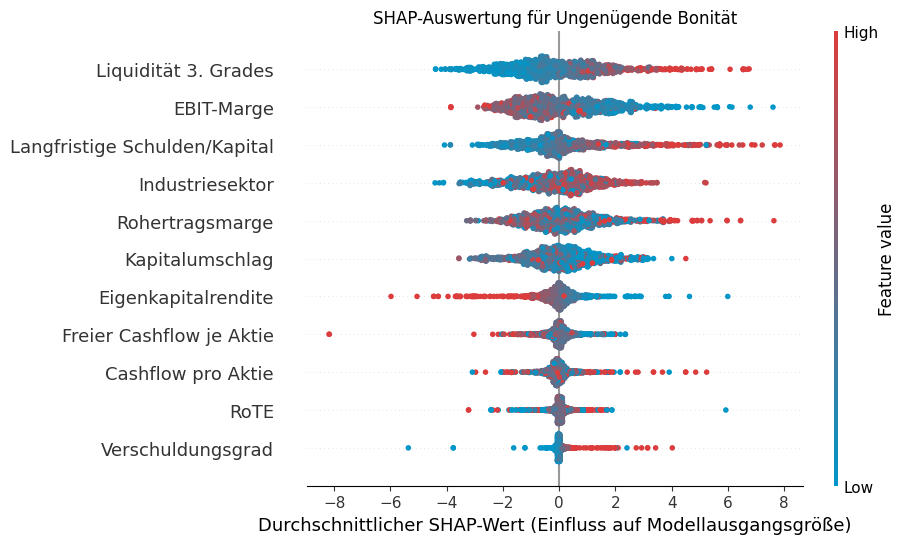

In [25]:
feature_names = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio', 
                 'Gross Margin', 'EBIT Margin', 'Asset Turnover', 'ROE - Return On Equity', 
                 'Return On Tangible Equity', 'Operating Cash Flow Per Share', 
                 'Free Cash Flow Per Share', 'Sector']

features_np = np.array(feature_names)

columns_german = {
    'Gross Margin': 'Rohertragsmarge', 'Current Ratio': 'Liquidität 3. Grades', 'Long-term Debt / Capital': 'Langfristige Schulden/Kapital', 'Debt/Equity Ratio': 'Verschuldungsgrad',
      'EBIT Margin': 'EBIT-Marge', 'Asset Turnover': 'Kapitalumschlag', 'ROE - Return On Equity': 'Eigenkapitalrendite', 'Return On Tangible Equity': 'RoTE',
        'Operating Cash Flow Per Share': 'Cashflow pro Aktie', 'Free Cash Flow Per Share': 'Freier Cashflow je Aktie', 'Sector': 'Industriesektor'
        }

feature_names = np.vectorize(columns_german.get)(features_np)

RGB_val = 255

color01= (0,150,200)  # Blue wanted
color04= (220,60,60)  # red wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]



GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')


class_names = ['Sehr Hohe Bonität', 'Gute Bonität', 'Befriedigende Bonität', 'Angespannte Bonität', 'Mangelhafte Bonität', 'Ungenügende Bonität']

for i, class_name in enumerate(class_names):
  plt.figure()
  shap.summary_plot(shap_values[i], X_test.detach().cpu().numpy(), show=False, feature_names=feature_names)
  ax = plt.gca()
  ax.set_xlabel('Durchschnittlicher SHAP-Wert (Einfluss auf Modellausgangsgröße)')
  plt.gcf().axes[-1].set_aspect(100)
  plt.gcf().axes[-1].set_box_aspect(100)
  plt.title(f'SHAP-Auswertung für {class_name}')

  # Change the colormap of the artists
  for fc in plt.gcf().get_children():
      for fcc in fc.get_children():
          if hasattr(fcc, "set_cmap"):
              fcc.set_cmap(newcmp)

  plt.savefig(os.path.join('torch_eval', 'shap_values', f'{class_name}_shap.png'), bbox_inches='tight', dpi=300)

## Absolute SHAP values for feature importance

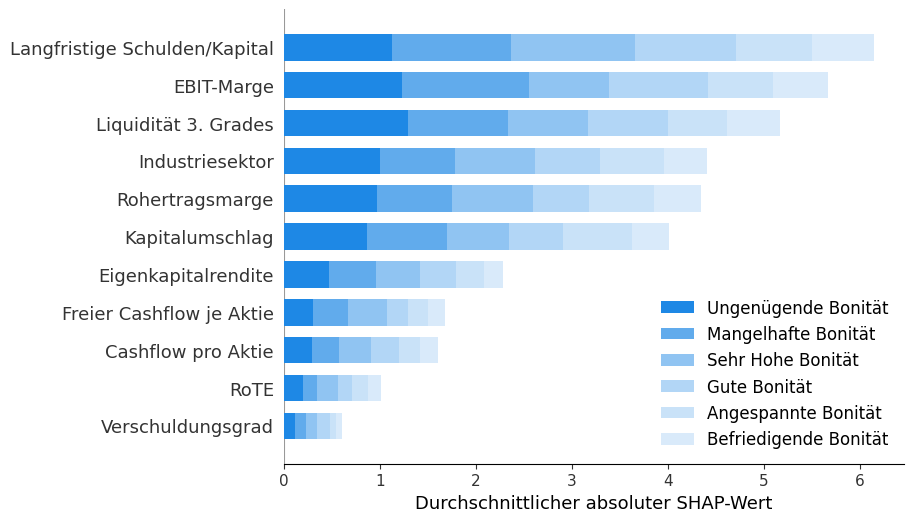

In [34]:
plt.figure()
shap.summary_plot(shap_values, X_test.detach().cpu().numpy(), feature_names=feature_names, class_names=class_names, show=False)
summ = plt.gca()
summ.set_xlabel('Durchschnittlicher absoluter SHAP-Wert')
plt.show()

## Multi-dimensional feature analysis with SHAP values

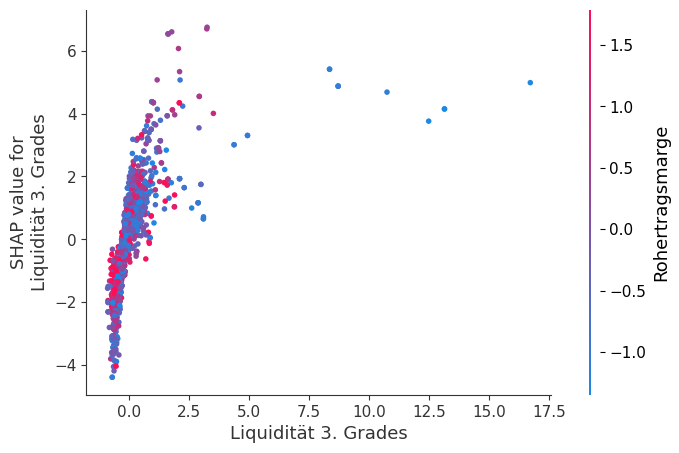

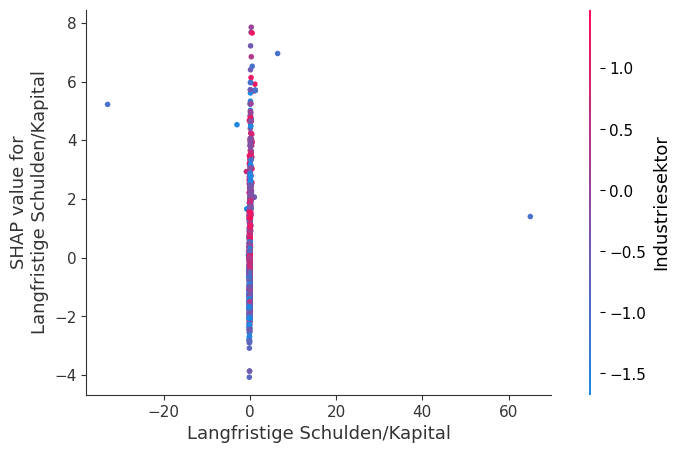

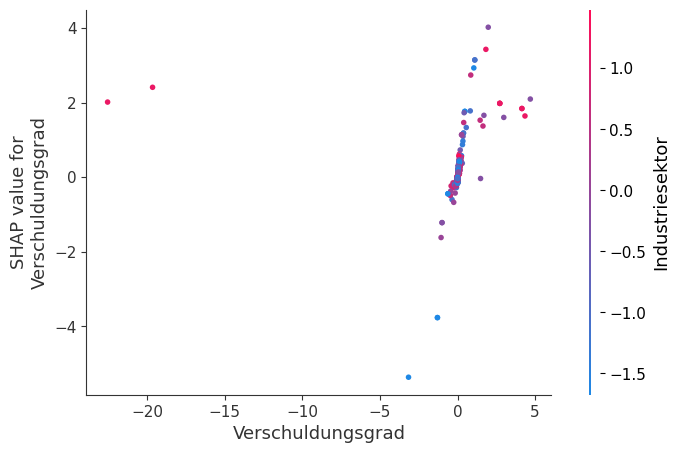

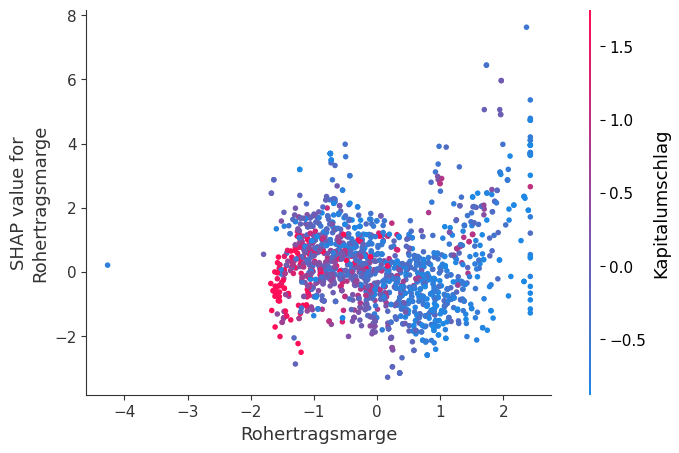

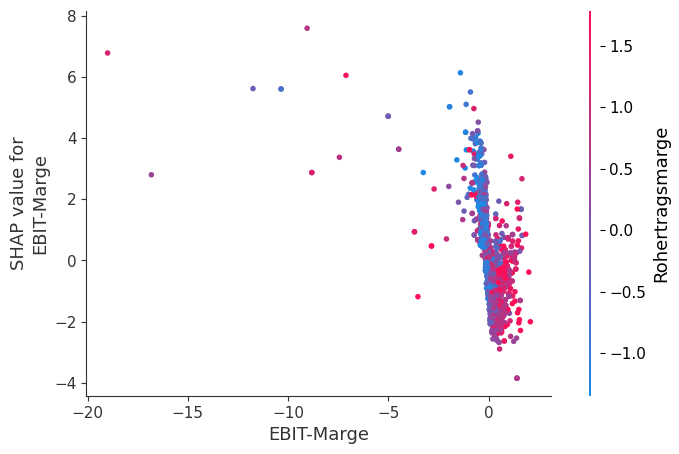

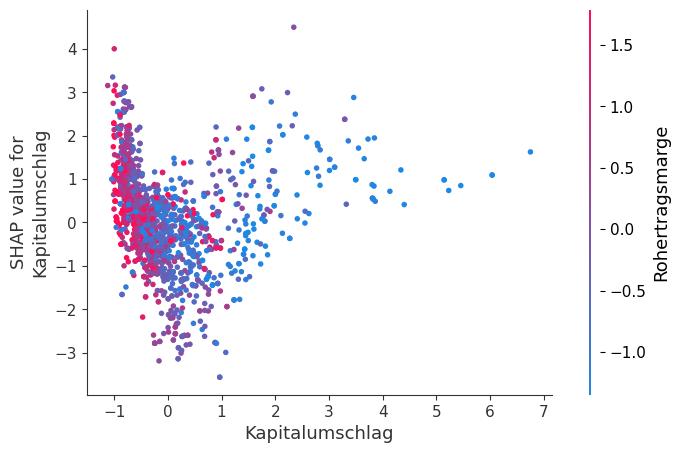

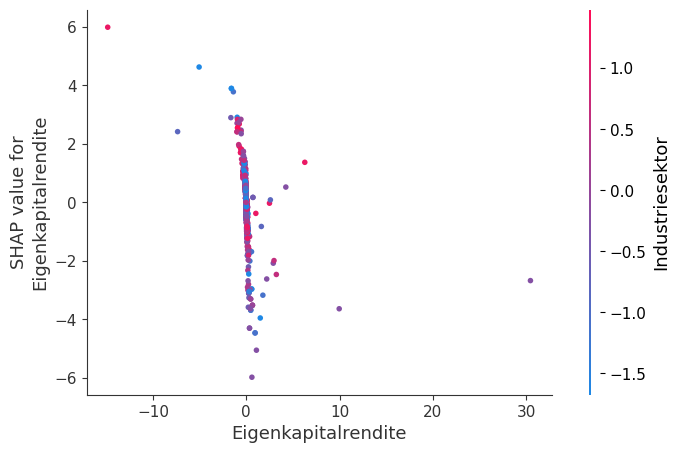

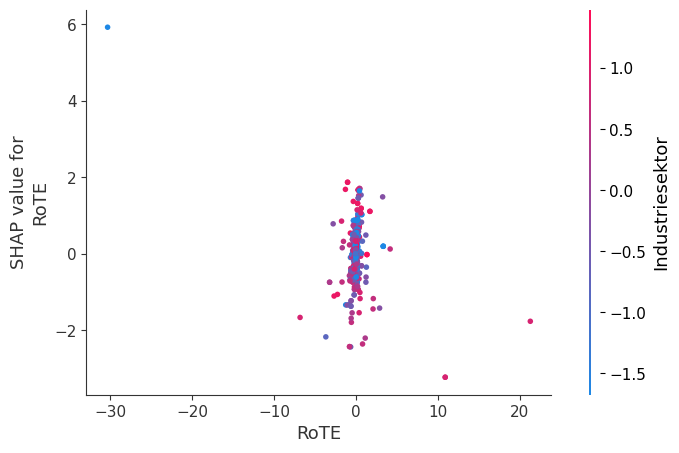

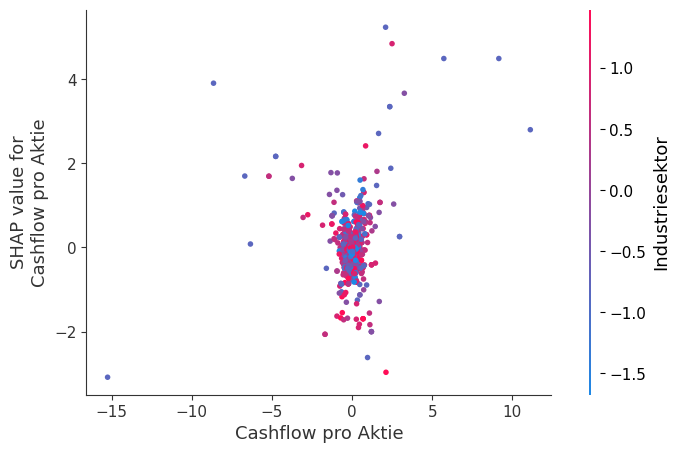

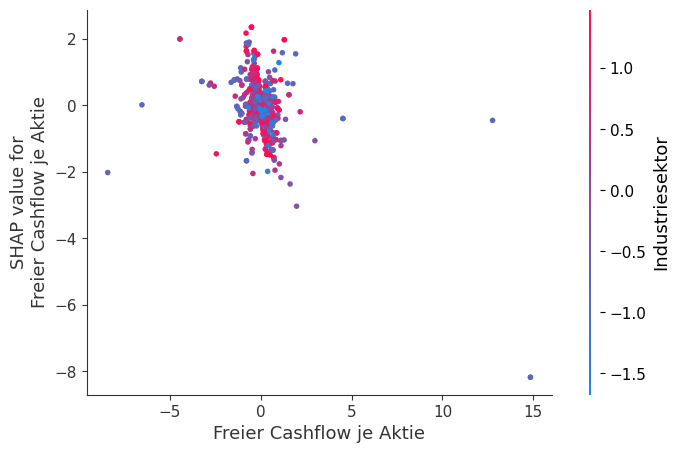

In [11]:
for i in range(10):
    shap.dependence_plot(i, shap_values[5], X_test.cpu().numpy(), feature_names=feature_names)

In [17]:
class_names = ['Sehr Hohe Bonität', 'Gute Bonität', 'Befriedigende Bonität', 'Angespannte Bonität', 'Mangelhafte Bonität', 'Ungenügende Bonität']
shap_output = {}

# Print the SHAP values for the first instance in the test set, for each class
for i, class_name in enumerate(class_names):
    print(f"SHAP values for class '{class_name}' for the first instance in the test set:")
    print(shap_values[i][0, :])
    shap_output[class_name] = shap_values[i]

SHAP values for class 'Sehr Hohe Bonität' for the first instance in the test set:
[ 0.55222859 -0.58749464 -0.13718521 -1.70908844 -0.14156981  0.49806351
  0.29178897  0.0951191   0.0925936   0.12901148  0.1660109 ]
SHAP values for class 'Gute Bonität' for the first instance in the test set:
[ 0.38278164 -0.42145986 -0.08649742 -0.61402054 -1.14347368  0.10966103
  0.18550555  0.0522949  -0.65838943 -0.0651128  -0.54389094]
SHAP values for class 'Befriedigende Bonität' for the first instance in the test set:
[ 0.48696596 -0.19648021 -0.04760432  0.37044044 -0.26261234  0.96046699
  0.16938733  0.02508789  0.30574945 -0.01870378 -0.39343617]
SHAP values for class 'Angespannte Bonität' for the first instance in the test set:
[-0.36853485  0.52201023  0.1133278   0.80624115  0.33913322 -0.00367685
 -0.13630618  0.00197529 -0.4632993  -0.01909116  0.2316283 ]
SHAP values for class 'Mangelhafte Bonität' for the first instance in the test set:
[-0.58947912  0.65003403  0.13275539  0.4760386

In [8]:
feature_names = ['Liquidität 3. Grades', 'Langfristige Schulden/Kapital', 'Verschuldungsgrad', 
                 'Rohertragsmarge', 'EBIT-Marge', 'Kapitalumschlag', 'Eigenkapitalrendite', 
                 'RoTE', 'Cashflow pro Aktie', 'Freier Cashflow je Aktie', 'Industriesektor']

shap_values_dict = {
    'Sehr Hohe Bonität': [0.47789154, -0.64632323, -0.16862193, -1.04821226, -0.42890314, 
                            1.06719644, 0.30228051, 0.10320689, 0.18002719, 0.15263173, -0.30151146],
    'Gute Bonität': [0.34192486, -0.48533625, -0.13669137, -0.16866295, -1.40898241, 
                            1.55350968, 0.19770538, 0.05269735, -0.33281611, -0.00663907, -0.4442778],
    'Befriedigende Bonität': [0.29385535, -0.11629864, -0.05518983, 0.09211714, -0.42361235, 
                          1.69511815, 0.14443634, 0.02591386, 0.06533072, 0.00412497, -0.40926871],
    'Angespannte Bonität': [-0.13641903, 0.37448442, 0.09501897, 0.31404781, 0.74185603, 
                     0.79646759, -0.03327588, -0.00697361, -0.38631953, 0.11689969, 0.19009102],
    'Mangelhafte Bonität': [-0.47394494, 0.75598425, 0.14785748, 0.93447932, 1.88514258, 
                            -0.72108189, -0.13156063, 0.01280024, 1.33304367, -0.08094898, 1.32267201],
    'Ungenügende Bonität': [-0.63427032, 0.52901964, 0.09194453, 0.71062267, 1.46916313, 
                              0.52221754, -0.0933804, 0.04249627, 0.65363918, -0.06946885, 1.26123461]
}

df = pd.DataFrame(shap_values_dict, index=feature_names)
df.to_excel(os.path.join('torch_eval', 'SHAP_scores.xlsx'))

## Permutation importance

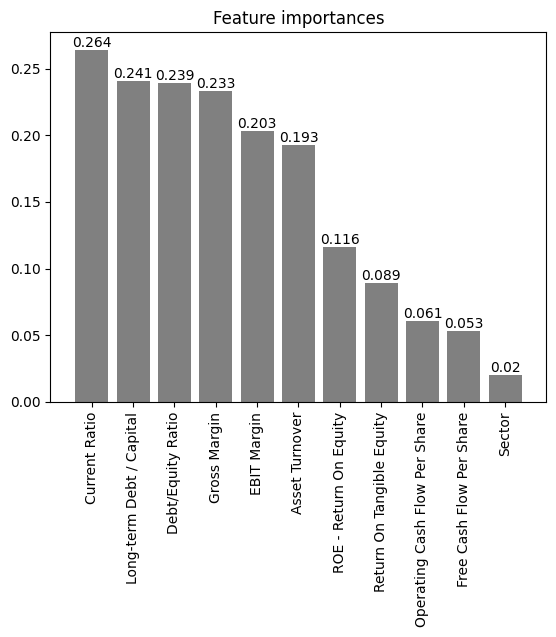

In [6]:
class SklearnWrapper:
    def __init__(self, model: nn.Module, device: str):
        self.model = model
        self.device = device

    def fit(self, X: np.ndarray, y: np.ndarray):
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = torch.tensor(X, dtype=torch.float).to(device)
        self.model.eval()
        with torch.no_grad():
            output = self.model(X)
        return np.argmax(output.cpu().numpy(), axis=1)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.predict(X)
        return (y_pred == y).mean()

def measure_importance(model: nn.Module, X_test: torch.Tensor, y_test: torch.Tensor) -> np.ndarray:
    model_sklearn = SklearnWrapper(model, device)
    X_test_np = X_test.cpu().numpy()
    y_test_np = np.argmax(y_test.cpu().numpy(), axis=1)
    r = permutation_importance(model_sklearn, X_test_np, y_test_np, n_repeats=30)
    return r

r = measure_importance(model, X_test, y_test)

importances = r.importances_mean
std = r.importances_std
indices = np.argsort(importances)[::-1]

importances = np.round(importances, decimals=3)

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="grey", align="center")
plt.xticks(range(X_test.shape[1]), cols_to_keep, rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
ax = plt.subplot()
plt.bar_label(ax.containers[0])
plt.show()


In [12]:
cols_to_keep

columns_german = {
    'Gross Margin': 'Rohertragsmarge', 'Current Ratio': 'Liquidität 3. Grades', 'Long-term Debt / Capital': 'Langfristige Schulden/Kapital', 'Debt/Equity Ratio': 'Verschuldungsgrad',
    'EBIT Margin': 'EBIT-Marge', 'Asset Turnover': 'Kapitalumschlag', 'ROE - Return On Equity': 'Eigenkapitalrendite', 'Return On Tangible Equity': 'RoTE',
        'Operating Cash Flow Per Share': 'Cashflow pro Aktie', 'Free Cash Flow Per Share': 'Freier Cashflow je Aktie', 'Sector': 'Industriesektor'
        }


cols_to_keep = np.vectorize(columns_german.get)(np.array(cols_to_keep))

print(cols_to_keep)

['Liquidität 3. Grades' 'Langfristige Schulden/Kapital'
 'Verschuldungsgrad' 'Rohertragsmarge' 'EBIT-Marge' 'Kapitalumschlag'
 'Eigenkapitalrendite' 'RoTE' 'Cashflow pro Aktie'
 'Freier Cashflow je Aktie' 'Industriesektor']


In [17]:
def translate_features(feature_list):
    columns_german = {
    'Gross Margin': 'Rohertragsmarge', 'Current Ratio': 'Liquidität 3. Grades', 'Long-term Debt / Capital': 'Langfristige Schulden/Kapital', 'Debt/Equity Ratio': 'Verschuldungsgrad',
    'EBIT Margin': 'EBIT-Marge', 'Asset Turnover': 'Kapitalumschlag', 'ROE - Return On Equity': 'Eigenkapitalrendite', 'Return On Tangible Equity': 'RoTE',
        'Operating Cash Flow Per Share': 'Cashflow pro Aktie', 'Free Cash Flow Per Share': 'Freier Cashflow je Aktie', 'Sector': 'Industriesektor'
        }
    translated_list = np.vectorize(columns_german.get)(np.array(feature_list)).tolist()

    return translated_list


features_german = translate_features(cols_to_keep)

print(features_german)

['Liquidität 3. Grades', 'Langfristige Schulden/Kapital', 'Verschuldungsgrad', 'Rohertragsmarge', 'EBIT-Marge', 'Kapitalumschlag', 'Eigenkapitalrendite', 'RoTE', 'Cashflow pro Aktie', 'Freier Cashflow je Aktie', 'Industriesektor']
